# Comparing the different proposed models

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

from scipy.stats import poisson, norm, invgamma

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
J = 6

np.random.seed(111)
N = poisson.rvs(3, size=J, loc=10)

MU  = -9
TAU = 1
RHO = 3
NU  = 4

np.random.seed(111)
THETA  = norm.rvs(size=J, loc=MU, scale=TAU)
SIGMA2 = invgamma.rvs(size=J, a=NU/2, scale=NU/2*RHO**2)

SIGMA = np.sqrt(SIGMA2)

ALPHA_LEVEL = 0.05

VARIABLE = 'Y'
COMPARE_METRIC = 'waic' # metric for comparing the models, options are 'waic' or 'loo'

Create the data

In [3]:
Y = norm.rvs(size=N[0], loc=THETA[0], scale=SIGMA[0])
Dat = pd.DataFrame(np.array([Y, [0]*N[0]]).T)

for j in range(1,J):
    Y = norm.rvs(size=N[j], loc=THETA[j], scale=SIGMA[j])
    DatAux = pd.DataFrame(np.array([Y, [j]*N[j]]).T)
    Dat = pd.concat([Dat, DatAux])

Dat = Dat.rename(columns={0:VARIABLE, 1:'Region'})
Dat['Region'] = Dat['Region'].astype(int)

Calculate the statistics per region

In [4]:
DatRegion = Dat[[VARIABLE, 'Region']].groupby('Region').agg(['count', 'mean', 'std']).reset_index()

DatRegion.columns = DatRegion.columns.droplevel()

DatRegion = DatRegion.rename(
    columns={
        '':'Region'
        , 'count': 'NumberObservations'
        , 'mean': VARIABLE + 'Mean'
        , 'std': VARIABLE + 'Std'}
    )

DatRegion['Theta'] = THETA
DatRegion['Sigma'] = SIGMA

In [5]:
Dat = pd.merge(
    Dat
    , DatRegion[['Region', VARIABLE + 'Mean', VARIABLE + 'Std']]
)

---

Estimate $\nu$

In [6]:
ES2 = (DatRegion[VARIABLE + 'Std']**2).mean()
VS2 = (DatRegion[VARIABLE + 'Std']**2).var()

In [7]:
HatNu = 2 * ES2**2 / VS2 + 4

----

Separate models for each region

In [8]:
with pm.Model() as ModelSeparate:
    Sigma = pm.HalfFlat('Sigma', shape=J)
    pm.Potential('p(Sigma)', -pm.math.log(Sigma))

    Theta  = pm.Flat('Theta', shape=J)

    Income = pm.Normal('Income', mu=Theta[Dat['Region']], sigma=Sigma[Dat['Region']], observed=Dat[VARIABLE])

Pooled model

In [9]:
with pm.Model() as ModelPooled:
    Sigma = pm.HalfFlat('Sigma')
    pm.Potential('p(Sigma)', -pm.math.log(Sigma))

    Theta  = pm.Flat('Theta')
    
    Income = pm.Normal('Income', mu=Theta, sigma=Sigma, observed=Dat[VARIABLE])

Model with common $\sigma^2$

In [10]:
with pm.Model() as ModelCommonSigma:
    Sigma = pm.HalfFlat('Sigma')
    pm.Potential('p(Sigma)', -pm.math.log(Sigma))

    Tau    = pm.HalfFlat('Tau')
    Mu     = pm.Flat('Mu')
    Theta  = pm.Normal('Theta', mu=Mu, sigma=Tau, shape=J)

    Income = pm.Normal('Income', mu=Theta[Dat['Region']], sigma=Sigma, observed=Dat[VARIABLE])

Model with non-common $\sigma^2$ and estimated $\nu$

In [11]:
with pm.Model() as ModelEstimatedNu:
    Rho    = pm.HalfFlat('Rho')
    pm.Potential('p(Rho)', -pm.math.log(Rho))

    Sigma2 = pm.InverseGamma('Sigma2', alpha=HatNu/2, beta=HatNu/2 * Rho**2, shape=J)
    Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

    Tau    = pm.HalfFlat('Tau')
    Mu     = pm.Flat('Mu')
    Theta  = pm.Normal('Theta', mu=Mu, sigma=Tau, shape=J)

    Income = pm.Normal('Income', mu=Theta[Dat['Region']], sigma=Sigma[Dat['Region']], observed=Dat[VARIABLE])

Model with non-common $\sigma^2$ and $\nu\sim\textsf{Exponential}(1/\hat\nu)$

In [12]:
with pm.Model() as ModelExponentialNu:
    Rho    = pm.HalfFlat('Rho')
    pm.Potential('p(Rho)', -pm.math.log(Rho))

    Nu = pm.Exponential('Nu', lam=1/HatNu)

    Sigma2 = pm.InverseGamma('Sigma2', alpha=HatNu/2, beta=HatNu/2 * Rho**2, shape=J)
    Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

    Tau    = pm.HalfFlat('Tau')
    Mu     = pm.Flat('Mu')
    Theta  = pm.Normal('Theta', mu=Mu, sigma=Tau, shape=J)

    Income = pm.Normal('Income', mu=Theta[Dat['Region']], sigma=Sigma[Dat['Region']], observed=Dat[VARIABLE])

Model with non-common $\sigma^2$ and $p(\nu)\propto 1/\nu^3$

In [13]:
with pm.Model() as ModelH3:
    Rho    = pm.HalfFlat('Rho')
    pm.Potential('p(Rho)', -pm.math.log(Rho))

    Nu     = pm.HalfFlat('Nu')
    pm.Potential('p(Nu)', -3*pm.math.log(Nu))

    Sigma2 = pm.InverseGamma('Sigma2', alpha=Nu/2, beta=Nu/2 * Rho**2, shape=J)
    Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

    Tau    = pm.HalfFlat('Tau')
    Mu     = pm.Flat('Mu')
    Theta  = pm.Normal('Theta', mu=Mu, sigma=Tau, shape=J)

    Income = pm.Normal('Income', mu=Theta[Dat['Region']], sigma=Sigma[Dat['Region']], observed=Dat[VARIABLE])

Model with non-common $\sigma^2$ and $p(\nu)\propto 1/\nu^2$

In [14]:
with pm.Model() as ModelH2:
    Rho    = pm.HalfFlat('Rho')
    pm.Potential('p(Rho)', -pm.math.log(Rho))

    Nu     = pm.HalfFlat('Nu')
    pm.Potential('p(Nu)', -2*pm.math.log(Nu))

    Sigma2 = pm.InverseGamma('Sigma2', alpha=Nu/2, beta=Nu/2 * Rho**2, shape=J)
    Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

    Tau    = pm.HalfFlat('Tau')
    Mu     = pm.Flat('Mu')
    Theta  = pm.Normal('Theta', mu=Mu, sigma=Tau, shape=J)

    Income = pm.Normal('Income', mu=Theta[Dat['Region']], sigma=Sigma[Dat['Region']], observed=Dat[VARIABLE])

Model with non-common $\sigma^2$ and $p(\nu)\propto 1/\nu$

In [15]:
with pm.Model() as ModelH1:
    Rho    = pm.HalfFlat('Rho')
    pm.Potential('p(Rho)', -pm.math.log(Rho))

    Nu     = pm.HalfFlat('Nu')
    pm.Potential('p(Nu)', -pm.math.log(Nu))

    Sigma2 = pm.InverseGamma('Sigma2', alpha=Nu/2, beta=Nu/2 * Rho**2, shape=J)
    Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

    Tau    = pm.HalfFlat('Tau')
    Mu     = pm.Flat('Mu')
    Theta  = pm.Normal('Theta', mu=Mu, sigma=Tau, shape=J)

    Income = pm.Normal('Income', mu=Theta[Dat['Region']], sigma=Sigma[Dat['Region']], observed=Dat[VARIABLE])

---

Get a sample from the posterior

In [16]:
TraceSeparate    = pm.sample(model = ModelSeparate)
TracePooled      = pm.sample(model = ModelPooled)
TraceCommonSigma = pm.sample(model = ModelCommonSigma)
TraceEstimatedNu = pm.sample(model = ModelEstimatedNu)
TraceExponentialNu = pm.sample(model = ModelExponentialNu)
TraceH3          = pm.sample(model = ModelH3)
TraceH2          = pm.sample(model = ModelH2)
TraceH1          = pm.sample(model = ModelH1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, Tau, Mu, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho, Sigma2, Tau, Mu, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho, Nu, Sigma2, Tau, Mu, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho, Nu, Sigma2, Tau, Mu, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho, Nu, Sigma2, Tau, Mu, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 249 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho, Nu, Sigma2, Tau, Mu, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.


---

Compute the loglikelihood and compare the models

In [17]:
pm.compute_log_likelihood(TraceSeparate, model = ModelSeparate)
pm.compute_log_likelihood(TracePooled, model = ModelPooled)
pm.compute_log_likelihood(TraceCommonSigma, model = ModelCommonSigma)
pm.compute_log_likelihood(TraceEstimatedNu, model = ModelEstimatedNu)
pm.compute_log_likelihood(TraceExponentialNu, model = ModelExponentialNu)
pm.compute_log_likelihood(TraceH3, model = ModelH3)
pm.compute_log_likelihood(TraceH2, model = ModelH2)
pm.compute_log_likelihood(TraceH1, model = ModelH1)

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

---

Compare the models

In [18]:
CompareTable= az.compare(
    {
        "No Pooling": TraceSeparate
        , "Complete Pooling": TracePooled
        , "Common Sigma": TraceCommonSigma
        , "Estimated Nu": TraceEstimatedNu
        , "Exponential Nu": TraceExponentialNu
        , "H3": TraceH3
        , "H2": TraceH2
        , "H1": TraceH1
    }
    , ic = COMPARE_METRIC
    , scale = 'deviance'
)

In [19]:
CompareTable.loc[
    ['No Pooling', 'Complete Pooling', 'Common Sigma', 'Estimated Nu', 'Exponential Nu', 'H3', 'H2', 'H1']
    , 'elpd_' + COMPARE_METRIC
].round(2)

No Pooling          375.53
Complete Pooling    430.77
Common Sigma        430.25
Estimated Nu        374.80
Exponential Nu      374.47
H3                  373.61
H2                  373.62
H1                  374.32
Name: elpd_waic, dtype: float64

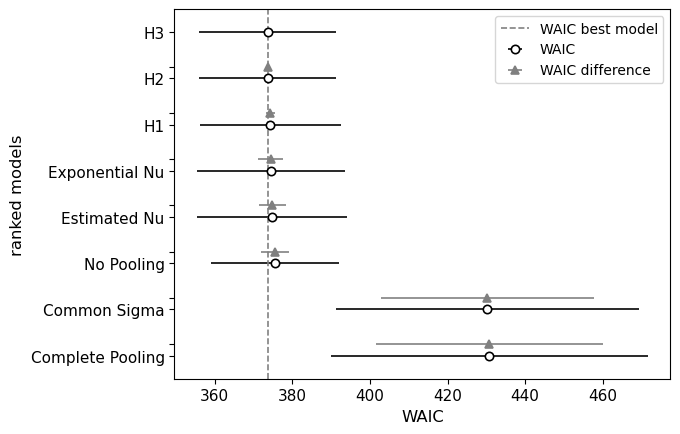

In [20]:
_, axes = plt.subplots(1,1)

az.plot_compare(
    CompareTable
    , textsize = 11
    , figsize = (10,5)
    , ax = axes
    , title =  False
    )

axes.set_xlabel(str.upper(COMPARE_METRIC))
axes.legend([str.upper(COMPARE_METRIC) + " best model", str.upper(COMPARE_METRIC), str.upper(COMPARE_METRIC) + ' difference'])